<h1 align='center'>Auto_ru Car Price Prediction</h1> 

В данной работе я проанализирую данные, выдвину некоторые гипотезы и проверю их, также моей задачей будет предсказание цены автомобилей <br>
для этого будут использованы различные методы кодирования категориальных переменных, изучена важность признаков и построена модель.

In [2388]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import shapiro, mannwhitneyu, kruskal
from sklearn.feature_selection import mutual_info_regression, f_regression, SequentialFeatureSelector, GenericUnivariateSelect
from sklearn.utils import resample

In [7]:
sns.set_theme(style='darkgrid')

In [8]:
%config IPCompleter.greedy=True

# Описание полей данных
<hr>
<ul>
    <li> bodyType - тип кузова    
    <li> brand - бренд
    <li> color - цвет (HEX)
    <li> fuelType - тип топлива
    <li> modelDate - год начала выпуска модели
    <li> name - дополнительная информация
    <li> numberOfDoors - количество дверей
    <li> productionDate - год выпуска автомобиля
    <li> vehicleConfiguration - конфигурация
    <li> vehicleTransmission - тип трансмиссии
    <li> engineDisplacement - объем двигателя
    <li> enginePower - количество л.с.
    <li> description - описание
    <li> mileage - пробег
    <li> Комплектация - комплектация
    <li> Привод - тип привода
    <li> Руль - расположение рулевого колеса
    <li> Состояние - состояние
    <li> Владельцы - количество владельцев
    <li> ПТС - тип ПТС
    <li> Таможня - растоможен ли автомобиль
    <li> Владение - владение
    <li> price - цена
    <li> start_date - дата объявления о продаже
    <li> hidden - hidden
    <li> model - модель
<ul/>

In [1452]:
data = pd.read_csv('all_auto_ru_09_09_2020.csv')
data.shape

(89378, 26)

In [1453]:
data.head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с....,4.0,1991,SEDAN MECHANICAL...,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09...,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL...,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49...,NaN,100


# Предобработка и визуализация данных

В наших данных присутствуют пропуски

In [1454]:
data.isna().sum()

bodyType                    1
brand                       0
color                       0
fuelType                    0
modelDate                   1
name                        1
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         1
engineDisplacement          1
enginePower                 1
description              3254
mileage                     0
Комплектация                0
Привод                      1
Руль                        0
Состояние               89378
Владельцы               13588
ПТС                       361
Таможня                     0
Владение                60177
price                     410
start_date                  0
hidden                  89378
model                       0
dtype: int64

In [1455]:
data.nunique()[data.nunique().values < 2]

Состояние    0
Таможня      1
hidden       0
dtype: int64

Удалим признаки с большим количеством пропусков, а также не несущих полезной информации

In [1456]:
data.drop(['Состояние','Владение','hidden','Таможня','vehicleConfiguration','Комплектация'], axis=1, inplace=True)

Приведем название наших признаков к одному виду

In [1457]:
data.columns = data.columns.str.lower()

In [1458]:
data.rename(columns={'привод':'drive', 'руль':'steering_wheel', 'владельцы':'owners', 'птс':'title'}, inplace=True)

У нас есть одинаковые объекты в данных, стоит их удалить

In [1459]:
data.duplicated().sum()

2114

In [1460]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [1461]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87264 entries, 0 to 87263
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodytype             87263 non-null  object 
 1   brand                87264 non-null  object 
 2   color                87264 non-null  object 
 3   fueltype             87264 non-null  object 
 4   modeldate            87263 non-null  float64
 5   name                 87263 non-null  object 
 6   numberofdoors        87263 non-null  float64
 7   productiondate       87264 non-null  int64  
 8   vehicletransmission  87263 non-null  object 
 9   enginedisplacement   87263 non-null  object 
 10  enginepower          87263 non-null  float64
 11  description          84031 non-null  object 
 12  mileage              87264 non-null  int64  
 13  drive                87263 non-null  object 
 14  steering_wheel       87264 non-null  object 
 15  owners               75247 non-null 

Мы можем понять, почему у нас пропущены значения кол-ва владельцев <br>
у тех авто, где пробег нулевой, владельцев нет. Мы замений пропуск на 0

In [1462]:
nuniq_isna_owners = data[data.owners.isna()].nunique()
nuniq_isna_owners[nuniq_isna_owners < 2]

mileage    1
owners     0
title      1
dtype: int64

In [1463]:
data.owners.fillna(0, inplace=True)

In [1464]:
data.describe()

,modeldate,numberofdoors,productiondate,enginepower,mileage,owners,price
count,87263.000000,87263.000000,87264.000000,87263.000000,87264.000000,87264.000000,8.685400e+04
mean,2008.381147,4.507122,2010.673027,170.879766,137218.120176,1.926751,1.260892e+06
std,7.379264,0.655435,6.985727,83.635945,102351.069253,1.081041,1.923665e+06
min,1904.000000,0.000000,1904.000000,11.000000,0.000000,0.000000,1.600000e+04
25%,2005.000000,4.000000,2007.000000,115.000000,62000.000000,1.000000,3.500000e+05
50%,2009.000000,5.000000,2011.000000,150.000000,131506.000000,2.000000,6.490000e+05
75%,2014.000000,5.000000,2016.000000,199.000000,196000.000000,3.000000,1.400000e+06
max,2020.000000,5.000000,2020.000000,800.000000,1000000.000000,3.000000,9.900000e+07


Удалим единственный объект с аномально высокой ценой и уникальной моделью

In [1465]:
data[data.price == data.price.max()][['brand','model','price']]

,brand,model,price
55258,PORSCHE,918_SPYDER,99000000.0


In [1466]:
data = data[data.price != data.price.max()]

Заметим ровно <b> одну </b> уникальную машину с отсутвием дверей

In [1467]:
data.numberofdoors.value_counts()

5.0    50208
4.0    32980
3.0     2197
2.0     1876
0.0        1
Name: numberofdoors, dtype: int64

In [1468]:
data.query('numberofdoors == 0.0')[['brand','model','price']]

,brand,model,price
85970,MERCEDES,SIMPLEX,12000000.0


Так как она одна единственная в наших данных с уникальным признаком <br>
имеет смысл убрать такой объект

In [1469]:
data = data[data.numberofdoors != 0.0]

In [1470]:
data.reset_index(drop=True, inplace=True)

Удалим те объекты, в которых отсутствуют более 3-ех признаков

In [1471]:
bad_index = []
for i in range(len(data)):
    if data.iloc[i].isna().sum() > 3:
        bad_index.append(i)
data.drop(index=bad_index, inplace=True)

Уберем из данных также те объекты в которых пропущенна целевая переманная 'price'

In [1472]:
data.dropna(subset=['price'], inplace=True)

Теперь исправим наш признак 'engineDisplacement', т.к. он содержит <br>
не всегда правильный объем двигателя. Данные об объеме возьмем с признака 'name' 

In [1473]:
data.reset_index(drop=True, inplace=True)
data['engine_displacement_new'] = np.NaN

In [1474]:
for i in range(len(data.name)):
    try:
        if data.loc[i, 'fueltype'] == 'электро':
            data.loc[i, 'engine_displacement_new'] = 0
        else:    
            parts = data.loc[i, 'name'].split('.', maxsplit=1)
            data.loc[i, 'engine_displacement_new'] = float(parts[0][-1] + '.' + parts[1][0])
    except IndexError:
        data.loc[i, 'engine_displacement_new'] = 0
    except AttributeError:
        data.loc[i, 'engine_displacement_new'] = np.NaN

In [1787]:
data.drop('name', axis=1, inplace=True)

Также добавим конкретное название типа кузова, без указания доп. подробностей

In [1475]:
data['bodytype_new'] = np.NaN
for i in range(len(data)):
    data.loc[i, 'bodytype_new'] = data.loc[i, 'bodytype'].split(' ')[0]

Посмотрим сколько и где пропущенных значений у нас осталось, после преобразований

In [1476]:
data.isna().sum()[data.isna().sum() > 0]

description    3213
title           357
dtype: int64

Взглянем на экстремальные значения некоторых наших признаков

In [1477]:
data.agg({'price':['max','min'], 'mileage':['max','min'], 'productiondate':['max','min']})

,price,mileage,productiondate
max,68500000.0,1000000,2020
min,16000.0,0,1923


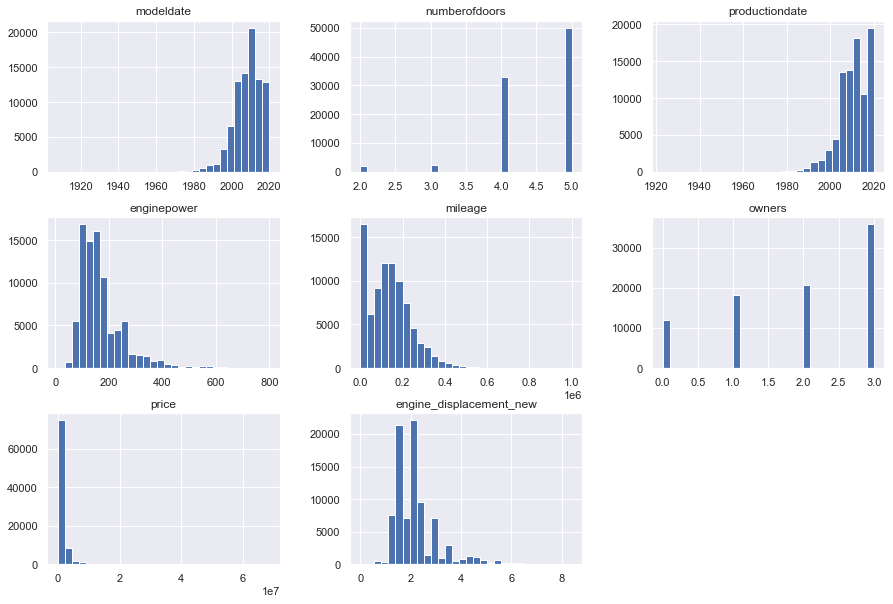

In [1478]:
data.hist(figsize=(15, 10), bins=30)
plt.show()

Видим, что значения наших числовых признаков скошены влево или вправо <br>
Также можно заметить большое количество авто с нулевым пробегом

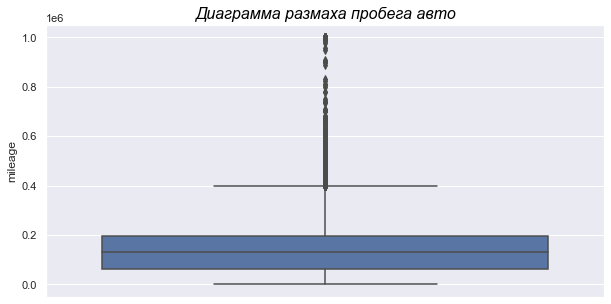

In [1479]:
plt.figure(figsize=(10,5))

plt.title('Диаграмма размаха пробега авто', color='black', fontsize=16, fontstyle='italic')
sns.boxplot(data=data, y='mileage')
plt.show()

Попробуем убрать некоторые экстремальные значения пробега

In [1480]:
q1 = data.mileage.quantile(q=.25)
q3 = data.mileage.quantile(q=.75)
iqr = q3 - q1

Удалим объекты у которых пробег больше двух межквартильных размахов <br>
Их оказалось не так много

In [1481]:
data[data.mileage > (q3 + 2*iqr)].shape[0]

480

In [1482]:
data = data[data.mileage < (q3 + 2*iqr)]
data.reset_index(drop=True, inplace=True)

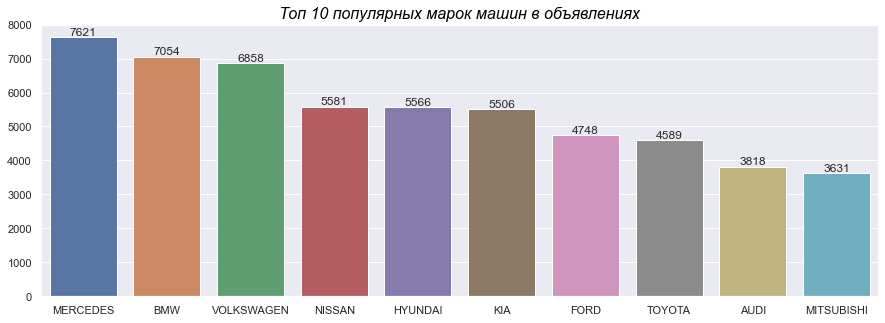

In [1483]:
plt.figure(figsize=(15,5))

plt.title('Топ 10 популярных марок машин в объявлениях', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(x=data.brand.value_counts().index[:10], y=data.brand.value_counts().values[:10])
ax.bar_label(ax.containers[0])
plt.show()

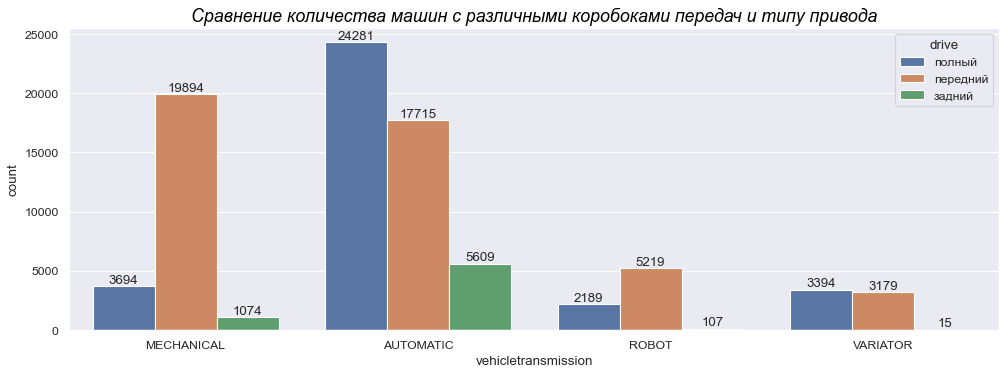

In [1484]:
plt.figure(figsize=(15,5), dpi=80)

plt.title('Сравнение количества машин с различными коробоками передач и типу привода', color='black', fontsize=16, fontstyle='italic')
ax = sns.countplot(data=data, x='vehicletransmission', hue='drive')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

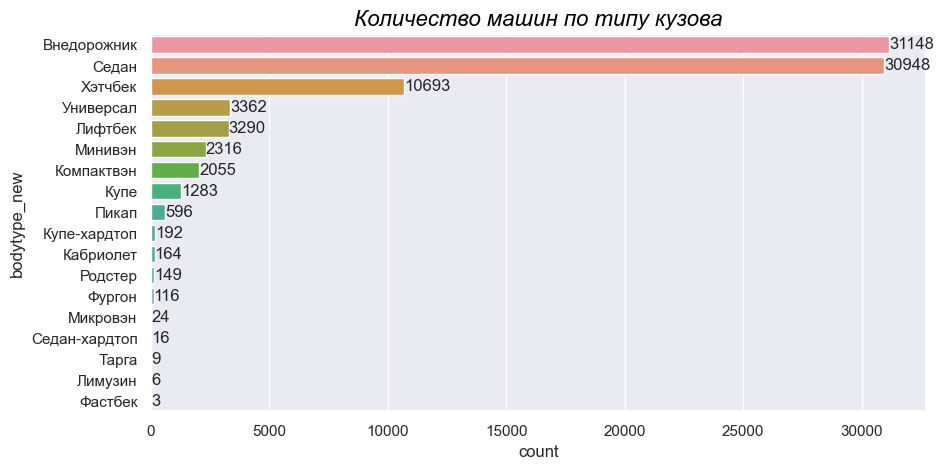

In [1485]:
plt.figure(figsize=(10,5), dpi=100)

plt.title('Количество машин по типу кузова', color='black', fontsize=16, fontstyle='italic')
order_category = data.bodytype_new.value_counts().index
ax = sns.countplot(data=data, y='bodytype_new', order=order_category)
ax.bar_label(ax.containers[0])
plt.show()

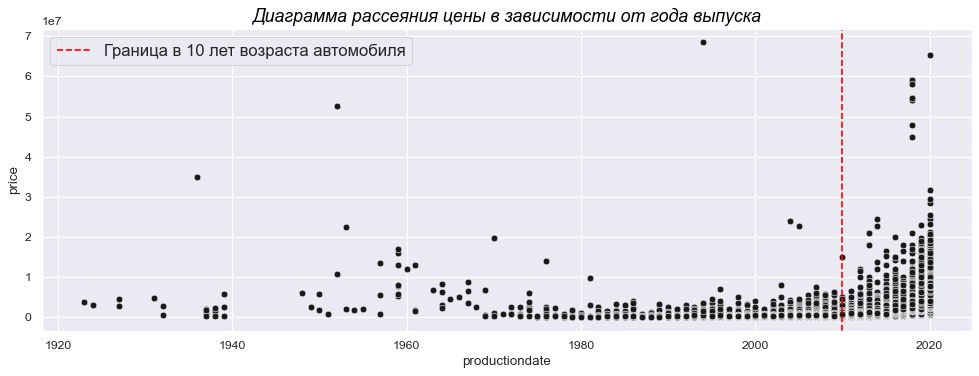

In [1486]:
plt.figure(figsize=(15,5), dpi=80)

plt.title('Диаграмма рассеяния цены в зависимости от года выпуска', color='black', fontsize=16, fontstyle='italic')
sns.scatterplot(data=data, x='productiondate', y='price', color='k')
plt.axvline(2010, color='red', linestyle='dashed', label='Граница в 10 лет возраста автомобиля')
plt.legend(fontsize=15)
plt.show()

Можно заметить некое количество машин выпуска до 1980 года с большей ценой, чем у новинок <br>
Также мы видим почти плавный спад цен в течение 10 лет. Взглянем поподробнее на эту интересную связь

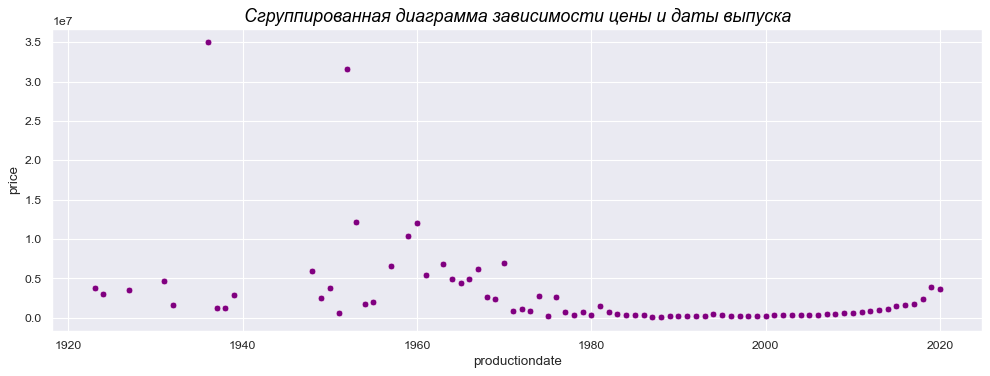

In [1487]:
plt.figure(figsize=(15,5), dpi=80)

plt.title('Сгруппированная диаграмма зависимости цены и даты выпуска', color='black', fontsize=16, fontstyle='italic')
prod_price_gr = data.groupby('productiondate', as_index=False).agg({'price':'mean'})
sns.scatterplot(data=prod_price_gr, x='productiondate', y='price', color='purple')
plt.show()

Сразу можно заметить необычное поведение цены авто после 1980-го года. <br>
Скорее всего цена на эти авто уже формируется своей уникальностью и редкостью, нежели техническим состоянием

<Figure size 800x400 with 0 Axes>

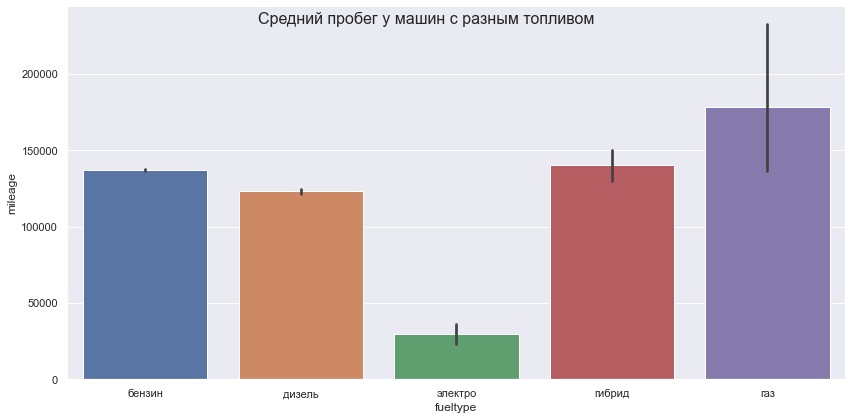

In [1488]:
plt.figure(figsize=(10,5), dpi=80)

sns.catplot(data=data, x='fueltype', y='mileage', aspect=2, height=6, kind='bar')
plt.suptitle('Средний пробег у машин с разным топливом', fontsize=16, y=0.96)
plt.show()

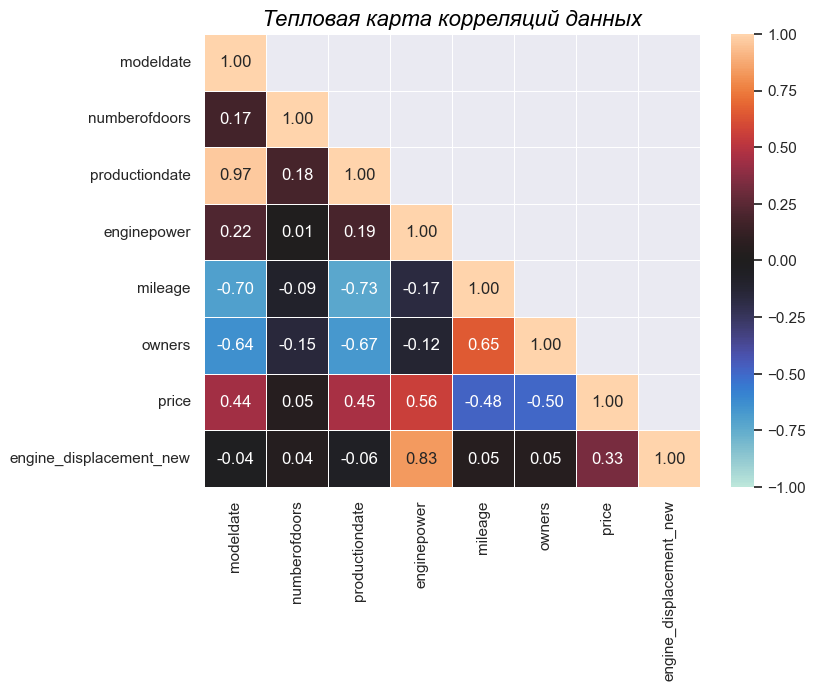

In [1489]:
matrix = np.triu(data.corr())
np.fill_diagonal(matrix, False)

plt.figure(figsize=(8,6), dpi=100)
plt.title('Тепловая карта корреляций данных', color='black', fontsize=16, fontstyle='italic')
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=.5, vmin=-1, center=0, vmax=1, mask=matrix)
plt.show()

Можем увидеть значимую корреляцию у некоторых признаков, особенно между нашими вновь созданными, <br>
что собственно неудивительно. Также абсолютно понятна зависимость пробега и года выпуска, а также мощности и объема

<b> Выдвенем гипотезы, которые мы в дальнейшем проверим </b>

<ol>
    <li> Автомобили с вариатором  дешевле, чем с роботизированной коробкой передач
    <li> Количество владельцев не влияет на пробег автомобиля
    <li> Кузов 'Cедан' имеет больший пробег у авто, чем  кузов 'Внедорожник'
<ol/>

<b> Первая гипотеза

Чтобы избежать дисбаланса классов и не потерять информацию, <br>
стоит использовать метод балансировки

In [1490]:
test.vehicletransmission.value_counts()[:][2:]

ROBOT       7516
VARIATOR    6591
Name: vehicletransmission, dtype: int64

In [1491]:
RO = data.query('vehicletransmission == "ROBOT"').price
VA = data.query('vehicletransmission == "VARIATOR"').price

In [1492]:
VA_balanced = resample(VA, replace=True, n_samples=len(RO))

Теперь убедимся, что данные имеют ненормальное распределение, <br>
но т.к тест Шапиро-Уилка не может принять больше 5000 значений, будем использовать бутстреп

In [1493]:
def bootsrap_distrib(k, data):
    mean_p = np.array([])
    for i in range(k):
        boot = np.random.choice(data, size=1000)
        mean_p = np.append(mean_p, shapiro(boot).pvalue)
    print(f'P-value {mean_p.mean()}')

In [1494]:
bootsrap_distrib(1000, pd.concat([RO,VA], axis=0))

P-value 2.4240693353767384e-29


Мы убеждаемся, что наши выборки имеют ненормальное распределение, значит будем использовать непараметрический критерий

<b> Нулевая гипотеза H0: цена машин с VA статистически не отличается от машин с RO 

In [1495]:
mannwhitneyu(VA_balanced, RO, alternative='less')

MannwhitneyuResult(statistic=29018439.0, pvalue=0.9983365621907065)

P-значение больше 0.05, мы принимаем нулевую гипотезу теста Манна-Уитни

<b> Вторая гипотеза

In [1496]:
data.owners.value_counts()

3.0    35482
2.0    20698
1.0    18192
0.0    11998
Name: owners, dtype: int64

Данные с 0 владельцев, мы естественно не учитываем

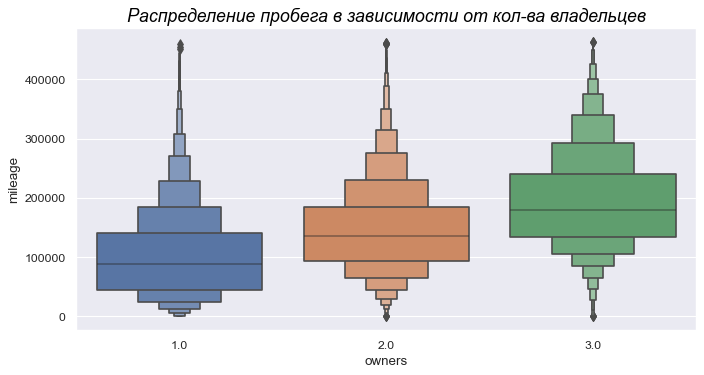

In [1497]:
plt.figure(figsize=(10,5), dpi=80)

plt.title('Распределение пробега в зависимости от кол-ва владельцев', color='black', fontsize=16, fontstyle='italic')
sns.boxenplot(data=data.query('owners != 0'), x='owners', y='mileage')

plt.show()

Убедимся, что пробег у нас имеет ненормальное распределение <br>
Мы будем использовать непарметрический тест Крускала-Уоллиса для проверки 2-ой гипотезы

In [1498]:
bootsrap_distrib(1000, data.mileage)

P-value 1.172609927042103e-15


In [1499]:
one_own = data.query('owners == 1').mileage
two_own = data.query('owners == 2').mileage
three_own = data.query('owners == 3').mileage

Так как статистика теста на полных данных слишком большая и приводит к не выводу p-значения, <br>
мы будем использовать бутстрап выборку, чтобы получить его в правильном виде

<b> Нулевая гипотеза H0: пробег машин с разным количеством владельцев статистически значимо не отличается

In [1500]:
bootstrapped_stats = []

for i in range(1000):
    resampled_one_own = resample(one_own, n_samples=1000)
    resampled_two_own = resample(two_own, n_samples=1000)
    resampled_three_own = resample(three_own, n_samples=1000)
    
    _, p_val = kruskal(resampled_one_own, resampled_two_own, resampled_three_own)
    bootstrapped_stats.append(p_val)

p_bootstrapped = np.mean(np.array(bootstrapped_stats))

In [1501]:
p_bootstrapped

1.4029407726211167e-115

P-значение меньше 0.05, мы отвергаем нулевую гипотезу теста Крускала-Уоллиса

<b> Третья гипотеза

In [1502]:
data.bodytype_new.value_counts()[:][:2]

Внедорожник    31148
Седан          30948
Name: bodytype_new, dtype: int64

Так как у нас есть новые авто без пробега, стоит убрать их из нашего теста

In [1503]:
sedan = data.query('(bodytype_new == "Седан") & (mileage != 0)').mileage
suv = data.query('(bodytype_new == "Внедорожник") & (mileage != 0)').mileage

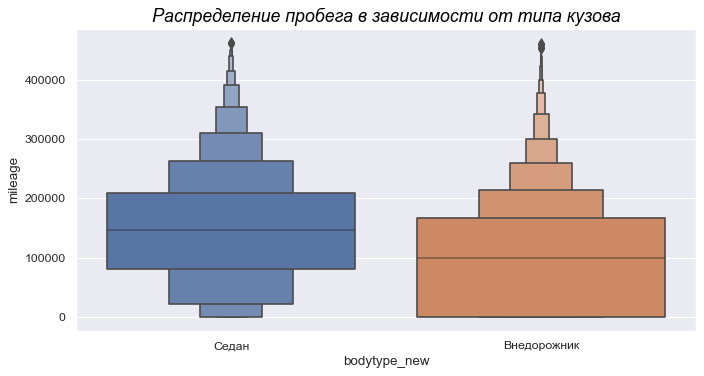

In [1504]:
plt.figure(figsize=(10,5), dpi=80)

plt.title('Распределение пробега в зависимости от типа кузова', color='black', fontsize=16, fontstyle='italic')
cbody_data = data[data.bodytype_new.isin(['Седан','Внедорожник'])]
sns.boxenplot(data=cbody_data, x='bodytype_new', y='mileage')

plt.show()

<b> Нулевая гипотеза H0: пробег машин в кузове седан не отличается от пробега машин в кузове внедорожник

In [1505]:
bootstrapped_stats = []

for i in range(100):
    resampled_sedan = resample(sedan, n_samples=1000)
    resampled_suv = resample(suv, n_samples=1000)
    
    _, p_val = mannwhitneyu(sedan, suv, alternative='greater')
    bootstrapped_stats.append(p_val)

p_bootstrapped = np.mean(np.array(bootstrapped_stats))

In [1506]:
p_bootstrapped

1.6867654485469268e-237

P-значение меньше 0.05, мы отвергаем нулевую гипотезу теста Манна-Уитни

Разберемся с нашими признаками у которых еще остались пропуски <br>
признак 'description' мы уберем, а title (ПТС) мы заполним

In [1507]:
data.drop('description', axis=1, inplace=True)

Заметим, что признак отстутсвует у некоторых авто только с нулевым пробегом <br>
возьмем моду по этому признаку у другиx авто с таким же пробегом

In [1508]:
data[data.title.isna()].mileage.unique()

array([0], dtype=int64)

In [1509]:
val = data[data.mileage == 0].title.mode().values[0]
data.title.fillna(val, inplace=True)

In [1510]:
data.start_date = pd.to_datetime(data.start_date)

# Feature engineering

Вспомним, что некоторые наши числовые признаки скошенны вправо <br>
проведем лог преобразование этих данных и добавим в наш датсет

In [1529]:
data['rarity'] = data.productiondate.apply(lambda x: 1 if x < 1980 else 0)

In [1533]:
data['ten_year'] = data.productiondate.apply(lambda x: 1 if (2020 - x) >= 10 else 0)

In [1619]:
num_data = data.select_dtypes(include=['float64','int64'])
num_data.drop('price', axis=1, inplace=True)
num_data['mileage_log'] = np.log(num_data.mileage + 1)
num_data['enginepower_log'] = np.log(num_data.enginepower + 1)

 Для оценки важности наших признаков будем использовать <b> "Методы фильтрации"

Числовые признаки
<hr>

mutual_info_regression - метод взаимной информации

In [1772]:
num_imp_mir = mutual_info_regression(num_data, data.price)

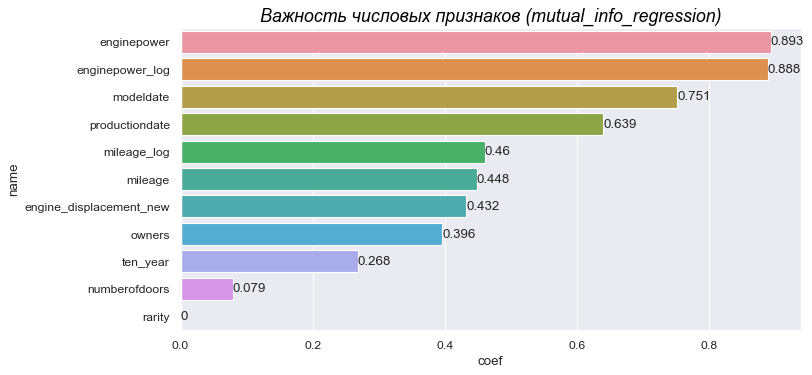

In [1871]:
plt.figure(figsize=(10,5), dpi=80)

num_frame = pd.DataFrame({'name':num_data.columns.values, 'coef':num_imp_mir})
num_frame.sort_values(by='coef', ascending=False, inplace=True)

plt.title('Важность числовых признаков (mutual_info_regression)', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=num_frame.name, x=np.round(num_frame.coef, 3))
ax.bar_label(ax.containers[0])
plt.show()

f_regression - одномерный линейный регрессионный тест

In [1777]:
num_imp_fr, _ = f_regression(num_data, data.price)

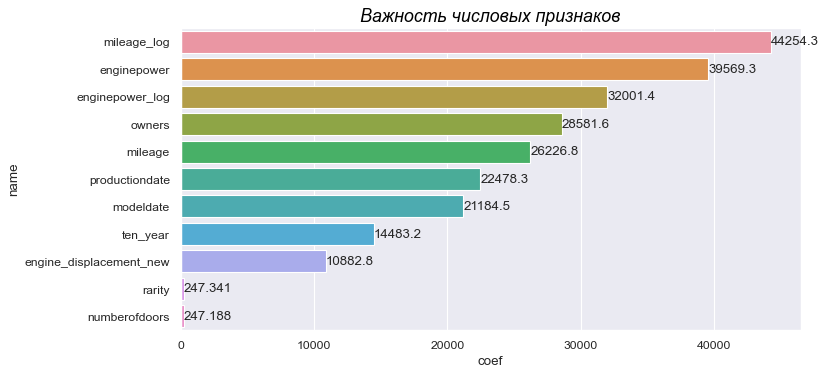

In [1778]:
plt.figure(figsize=(10,5), dpi=80)

num_frame_fr = pd.DataFrame({'name':num_data.columns.values, 'coef':num_imp_fr})
num_frame_fr.sort_values(by='coef', ascending=False, inplace=True)

plt.title('Важность числовых признаков (f_regression)', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=num_frame_fr.name, x=np.round(num_frame_fr.coef, 3))
ax.bar_label(ax.containers[0])
plt.show()

Категориальные признаки
<hr>

Для применения методов к категориальным признакам, преобразуем их в числоые с помощью <br>
pandas, использовать будем метод аналог LabelEncoder из sklearn

In [ ]:
cat_data = data.select_dtypes(include=['object'])
for col in cat_data:
    cat_data[col] = cat_data[col].astype('category').cat.codes

In [1780]:
cat_imp_mir = mutual_info_regression(cat_data, data.price)

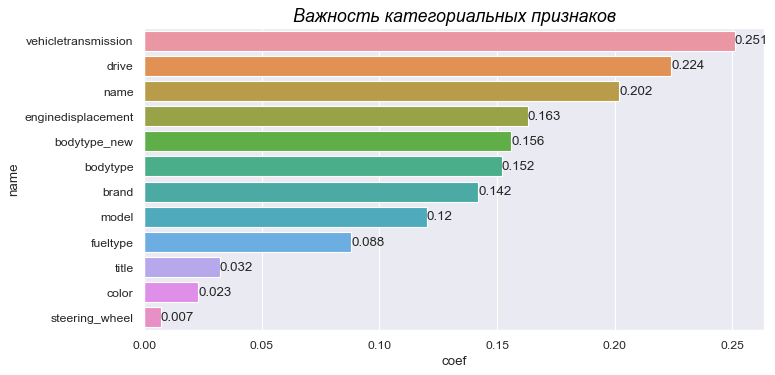

In [1781]:
plt.figure(figsize=(10,5), dpi=80)

cat_frame = pd.DataFrame({'name':cat_data.columns.values, 'coef':cat_imp_mir})
cat_frame.sort_values(by='coef', ascending=False, inplace=True)

plt.title('Важность категориальных признаков (mutual_info_regression)', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=cat_frame.name, x=np.round(cat_frame.coef, 3))
ax.bar_label(ax.containers[0])
plt.show()

In [1784]:
cat_imp_fr, _ = f_regression(cat_data, data.price)

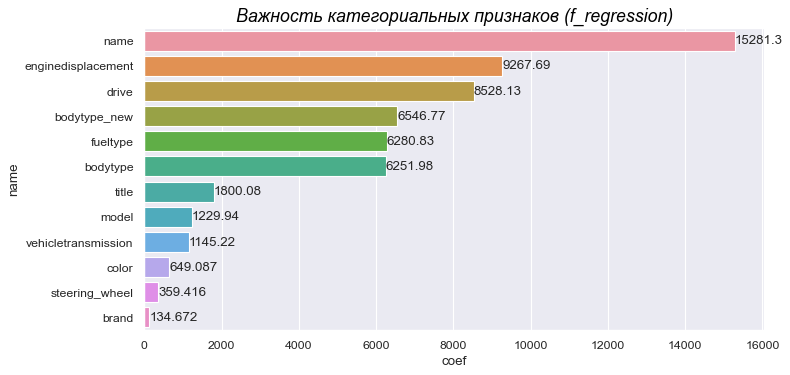

In [1872]:
plt.figure(figsize=(10,5), dpi=80)

cat_frame_fr = pd.DataFrame({'name':cat_data.columns.values, 'coef':cat_imp_fr})
cat_frame_fr.sort_values(by='coef', ascending=False, inplace=True)

plt.title('Важность категориальных признаков (f_regression)', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=cat_frame_fr.name, x=np.round(cat_frame_fr.coef, 3))
ax.bar_label(ax.containers[0])
plt.show()

Предварительно метод f_regression выделяет более логичные признаки

## Data encoding

Создадим датасет и закодируем категориальные переменные

In [2219]:
final_data = pd.DataFrame()

final_data['steering_wheel_is_right'] = data.steering_wheel.apply(lambda x: 1 if x == 'RIGHT' else 0)
final_data['title_is_orig'] = data.title.apply(lambda x: 1 if x == 'ORIGINAL' else 0)
final_data['rarity'] = data.productiondate.apply(lambda x: 1 if (2020 - x) > 10 else 0)
final_data['mileage_100'] = data.mileage.apply(lambda x: 1 if x > 100000 else 0)


final_data = pd.concat([final_data, pd.get_dummies(data.fueltype)], axis=1)
final_data = pd.concat([final_data, pd.get_dummies(data.vehicletransmission)], axis=1)
final_data = pd.concat([final_data, pd.get_dummies(data.drive)], axis=1)

final_data[['modeldate','productiondate','numberofdoors','engine_displacement_new','ten_year','owners']] = data[['modeldate','productiondate','numberofdoors','engine_displacement_new','ten_year','owners']]
final_data['random'] = np.random.random(size=len(data))

final_data['mileage_log'] = np.log(data.mileage + 1)
final_data['enginepower_log'] = np.log(data.enginepower + 1)

In [2220]:
def targer_encoding(data, col, target):
    target_dict = {}
    for cat in data[col].unique():
        target_mean = data[data[col] == cat][target].mean()
        target_dict[cat] = target_mean
    return data[col].map(target_dict) 

In [2221]:
final_data['model_encoded'] = targer_encoding(data, 'model', 'price')
final_data['brand_encoded'] = targer_encoding(data, 'brand', 'price')

In [2222]:
def target_encoding_smooth(data, col, target, smoothing=1):
    means = data.groupby(col)[target].mean()
    counts = data[col].value_counts()
    weights = counts / (counts + smoothing)
    smoothed_means = weights * means + (1 - weights) * np.mean(data[target])
    return data[col].map(smoothed_means)

In [2223]:
final_data['model_encoded_smooth'] = target_encoding_smooth(data, 'model', 'price', smoothing=0.5)
final_data['brand_encoded_smooth'] = targer_encoding(data, 'brand', 'price')

In [2224]:
def freq_encoding(data, col):
    freq = data[col].value_counts(normalize=True)
    return data[col].map(freq)

In [2225]:
final_data['brand_freq'] = freq_encoding(data, 'brand')
final_data['bodytype_new_freq'] = freq_encoding(data, 'bodytype_new')
final_data['color_freq'] = freq_encoding(data, 'color')
final_data['fueltype_freq'] = freq_encoding(data, 'fueltype')
final_data['model_freq'] = freq_encoding(data, 'model')
final_data['vehicletransmission_freq'] = freq_encoding(data, 'vehicletransmission')
final_data['drive_freq'] = freq_encoding(data, 'drive')

Проверем важность закодированных признаков

In [2229]:
X, _, y, _ = train_test_split(final_data, data.price)

In [2230]:
sel = GenericUnivariateSelect(score_func=f_regression, mode='k_best')
sel.fit(X, y)

final_test = pd.DataFrame(data={'score':sel.scores_}, 
             index=X.columns).sort_values(by='score',ascending=False)

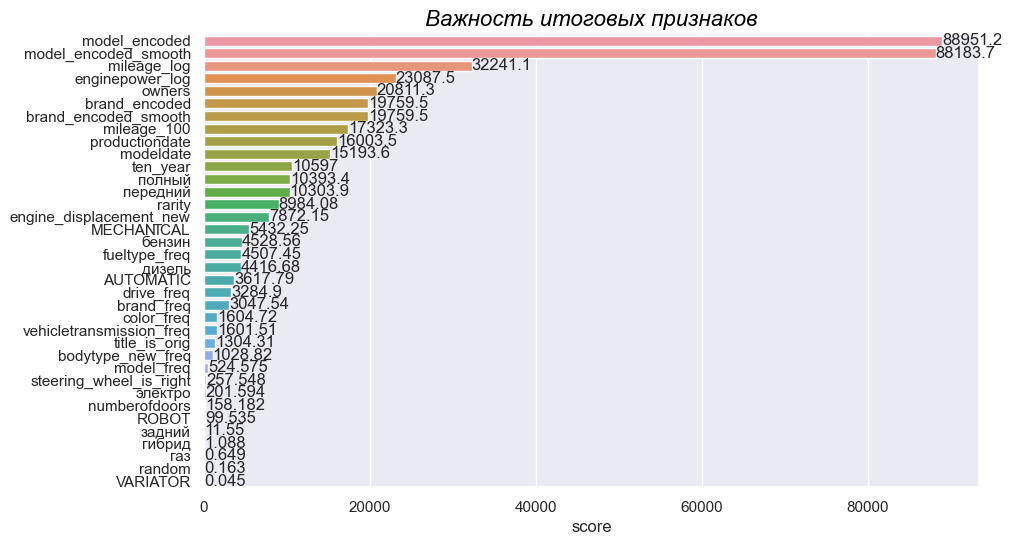

In [2231]:
plt.figure(figsize=(10,6), dpi=100)


plt.title('Важность итоговых признаков', color='black', fontsize=16, fontstyle='italic')
ax = sns.barplot(y=final_test.index, x=np.round(final_test.score, 3))
ax.bar_label(ax.containers[0])
plt.show()

Возьмем 11 самых важных переменных и это будет наш финальный датасет <br>
target_encoding будем использать со сглаживанием, так так некотороые модели могут быть уникальными, <br>
а сильно в качестве мы не потеряем

In [2238]:
final_data_fix = pd.DataFrame()
final_data_fix[['model_encoded_smooth', 'mileage_log', 'enginepower_log', 'owners','productiondate', 'rarity', 'ten_year', 'fueltype_freq', 'drive_freq', 'brand_freq', 'color_freq']] \
                = final_data[['model_encoded_smooth', 'mileage_log', 'enginepower_log', 'owners','productiondate', 'rarity', 'ten_year', 'fueltype_freq', 'drive_freq', 'brand_freq', 'color_freq']]

final_data_fix = pd.concat([final_data_fix, pd.get_dummies(data.vehicletransmission)], axis=1)

Первая модель будет RF, с параметрами по умолчанию

In [2215]:
rf = RandomForestRegressor(random_state=44)

In [2451]:
X_train, X_test, y_train, y_test = train_test_split(final_data_fix, data.price, random_state=44)

In [2452]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=44)

In [2453]:
pred_rf = rf.predict(X_test)

In [2454]:
mean_absolute_percentage_error(y_test, pred_rf)

0.14463833514523983

In [2455]:
mean_squared_error(y_test, pred_rf, squared=False)

397334.50229197316

Вспомним, что цена у нас тоже имеет вправо скошенное распределение <br>
поробуем обучаться на log-цене, а предсказания брать в экспоненте, это может улучшить наши метрики

In [2456]:
rf.fit(X_train, np.log(y_train))

RandomForestRegressor(random_state=44)

In [2457]:
pred_rf = np.exp(rf.predict(X_test))

In [2458]:
mean_absolute_percentage_error(y_test, pred_rf)

0.13527079310953313

In [2459]:
mean_squared_error(y_test, pred_rf, squared=False)

392786.86092120345

Как можем заметить, действительно наши метрики улучшились, <br>
для кросс-валидации будем использовать log вариант

In [2460]:
def cross_scoring(model, X, y, cv=3):
    kf_valid = KFold(n_splits=cv, random_state=44, shuffle=True)
    mape_score = []
    mse_score = []

    for train_index, test_index in kf_valid.split(X, y):
        X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
        y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
        
        model.fit(X_train, np.log(y_train))
        y_pred = np.exp(model.predict(X_test))
    
        mape_value = mean_absolute_percentage_error(y_test,y_pred)
        mse_value = mean_squared_error(y_test,y_pred, squared=False)

        mape_score.append(mape_value)
        mse_score.append(mse_value)
    return print(f' MAPE score: {np.mean(mape_score):0.4f} \n RMSE score: {np.mean(mse_score):0.4f}')    

In [2461]:
cross_scoring(rf, final_data_fix, data.price)

 MAPE score: 0.1356 
 RMSE score: 476838.3919


Как и следовало ожидать, на кросс-валидации наши метрики ухудшились

Проверим, где мы больше всего ошибаемся

In [2462]:
_, error_check, _, _ = train_test_split(data, data.price, random_state=44)

In [2473]:
error_check['RMSE'] = np.sqrt((error_check.price - np.round(pred_rf))**2)

In [2507]:
error_check[error_check.RMSE > 200000][['brand','bodytype_new','model','color','fueltype','numberofdoors',
                                        'productiondate','vehicletransmission','enginepower','mileage',
                                        'drive','steering_wheel','owners','title','price']].mode()

,brand,bodytype_new,model,color,fueltype,numberofdoors,productiondate,vehicletransmission,enginepower,mileage,drive,steering_wheel,owners,title,price
0,MERCEDES,Внедорожник,S_KLASSE,040001,бензин,5.0,2020,AUTOMATIC,249.0,0,полный,LEFT,0.0,ORIGINAL,1100000.0


Вот такие данные чаще всего нам встречаются при ошибке RMSE > 200.000

<b> Что можно было бы улучшить:
<ul>
    <li> Попробовать использовать признак "description", возможно это помогло бы избежать ошибок на новых машинах
    <li> Попробовать поднастроить модель RandomForestRegressor
    <li> Детальнее исследовать наши признаки
    <li> Использовать стекинг, для улучшения прогнозов    
<ul/>    